<a href="https://colab.research.google.com/github/dastuzh/M49-FDS20/blob/master/Practical_3_Files_Anic_Haller/ANN_Task_1/Practical_3_ANN_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 3: Artificial Neural Network

This is the first task of Practical 3. You will build a neural network to classify the handwritten digits from the MNIST dataset (http://yann.lecun.com/exdb/mnist/). 
You will build the classifier from scartch. 

We will mark your code based on the accuracy of your model. You should get **at least 97%** accuracy on this dataset. Don't forget to save and check in your model. 

## Import the libraries

In [ ]:
# We load the TensorBoard notebook extension and import tensorboard
%load_ext tensorboard

# Import the standard packages for this practical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

# We import some tools of Keras directly, such that our code gets more concise1
from keras.layers import Dense, Activation, Flatten, BatchNormalization, ELU, Dropout
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam

# Import the datatime and os package, which we need to label our training histories nicely in tensorboard
import datetime, os

# Import the package CyclicLR to use cyclical learning rates
!git clone https://github.com/bckenstler/CLR.git
from CLR.clr_callback import CyclicLR

Cloning into 'CLR'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 252 (delta 1), reused 4 (delta 0), pack-reused 244
Receiving objects: 100% (252/252), 2.06 MiB | 26.35 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [ ]:
tf.__version__

'2.4.0'

In [ ]:
tf.keras.__version__

'2.4.0'

In [ ]:
# Set global parameters for figures
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Prepare the dataset

In this block, you will prepare the data for the training, such as normalisation. 

11493376/11490434 [==============================] - 0s 0us/step


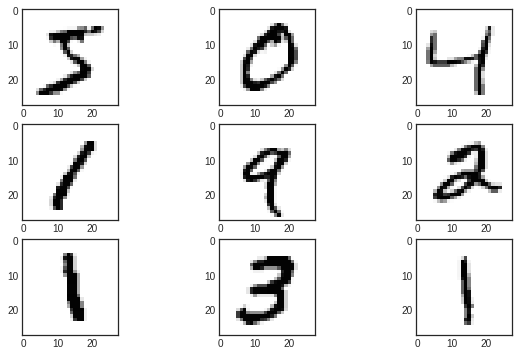

(60000, 28, 28)

In [ ]:
from keras.datasets import mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

X_train_full.shape

In [ ]:
# Normalize the input features, since modifying the values of each pixel such that they range from 0 to 1 will improve the rate at which our model learns 
## Note: we devide by a floating number, such that the integers are transformed into floats
X_train_full = X_train_full/255.0
X_test = X_test/255.0

In [ ]:
# Transform the classes within the label into a one-hot encoding matrix
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

y_train_full[5]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
# Get a validation dataset. We decide to take 6000 randomly chosen images from the full training data as the validation dataset
np.random.seed(77)
shuffler = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffler[:6000]], X_train_full[shuffler[6000:]]
y_valid, y_train = y_train_full[shuffler[:6000]], y_train_full[shuffler[6000:]]

## Build and train the model

Build and train your model. 

In [ ]:
# TODO: Build your model

## Initial model:
def create_init_model():

  # First we set up a Sequential Keras Model
  model = Sequential()
  # Add a flatten layer to transfrom the 28x28 inputs into a 1D array of length 784 (=28x28)
  model.add(Flatten(input_shape=[28, 28]))
  # Add a sequence of dense hidden layers with a decreasing number of neurons and relu activation functions
  # Note: These layers include a vector of bias terms by default
  model.add(Dense(500, activation="relu", kernel_initializer="he_normal"))
  model.add(Dense(200, activation="relu", kernel_initializer="he_normal"))
  model.add(Dense(100, activation="relu", kernel_initializer="he_normal"))
  model.add(Dense(50, activation="relu", kernel_initializer="he_normal"))
  # Add a dense output layer with 10 neurons (i.e. one per class in the label)
  model.add(Dense(10, activation="softmax"))

  # Compile the model (Normal)
  ## Note:
  ### As usual in classification problems we use the categorical crossentropy as the loss function
  ### We use the Adam method as the optimizer with learning rate 0.001
  ### We set the argument metrics to "accuracy", such that Keras computes and outputs the accuracy of the model on the validation set while it is trained
  model.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

  # Return the model
  return model

In [ ]:
# Define Callbacks
## To ensure that our model training histories are labelled nicely in tensorboard including a time indication of when the model has been fitted, 
## we define a variable to capture the exact logdirectory and assign this directory to the tensorboard callback afterwards.
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = TensorBoard(logdir, histogram_freq=1)

# To prevent overfitting, we introduce early stopping, such that the training is stopped as soon as no improovement has been monitored over 7 periods according to the validation accuracy
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

In [ ]:
# Train the initial model for different batch sizes
for bs in np.arange(30,110,10):
  # Create the initial model
  model = create_init_model()
  # Train the model
  history = model.fit(X_train, y_train, batch_size=bs, epochs=40, verbose=0,
                      validation_data=(X_valid, y_valid), 
                      callbacks=[early_stopping_cb, tensorboard_cb])
  # Calculate and display its validation accuracy for differing batch sizes
  val_acc = model.evaluate(X_valid, y_valid, verbose=0)[1]
  print('Using a batch size of', bs, 'the initial model achieves a validation accuracy of', val_acc)

Using a batch size of 30 the initial model achieves a validation accuracy of 0.981166660785675
Using a batch size of 40 the initial model achieves a validation accuracy of 0.9816666841506958
Using a batch size of 50 the initial model achieves a validation accuracy of 0.9831666946411133
Using a batch size of 60 the initial model achieves a validation accuracy of 0.981333315372467
Using a batch size of 70 the initial model achieves a validation accuracy of 0.9825000166893005
Using a batch size of 80 the initial model achieves a validation accuracy of 0.9815000295639038
Using a batch size of 90 the initial model achieves a validation accuracy of 0.9825000166893005
Using a batch size of 100 the initial model achieves a validation accuracy of 0.981333315372467


In [ ]:
# Define a function to create and compile a model
def create_model(n_hidden=2, nh_neurons=32, activ="relu", lr=0.001, batch_norm = False):
  # Depending on the activation function, set up the accordingly 'best' kernel initialization, which is "he_normal" for relu-type
  # activation functions and "lecun_normal" for the selu activation function. Since we only try-out relu, elu and selu, these two
  # initialization types should be sufficient.
  if activ == "selu":
    k_init = "lecun_normal"
  else:
    k_init = "he_normal"
  # Set up a sequential model
  model = Sequential()
  # Flatten layer
  model.add(Flatten(input_shape=[28, 28]))

  if batch_norm:
    # n_hidden Low level hidden layers
    for layer in range(n_hidden):
      nl_neurons = np.min([(4*nh_neurons),280])*2
      if nl_neurons < 300:
        nl_neurons = 400
      if nl_neurons > 560:
        nl_neurons = 500
      model.add(Dense(nl_neurons, activation=activ, kernel_initializer=k_init))
      model.add(BatchNormalization())

    # 3 High level hidden layers
    model.add(Dense(np.min([(4*nh_neurons),280]), activation=activ, kernel_initializer=k_init))
    model.add(BatchNormalization())
    model.add(Dense((2*nh_neurons), activation=activ, kernel_initializer=k_init))
    model.add(BatchNormalization())
    model.add(Dense(nh_neurons, activation=activ, kernel_initializer=k_init))

  else:
    # Flatten layer
    model.add(Flatten(input_shape=[28, 28]))
  
    # n_hidden Low level hidden layers
    for layer in range(n_hidden):
      nl_neurons = np.min([(4*nh_neurons),280])*2
      if nl_neurons < 300:
        nl_neurons = 400
      if nl_neurons > 560:
        nl_neurons = 500
      model.add(Dense(nl_neurons, activation=activ, kernel_initializer=k_init))
  
    # 3 High level hidden layers
    model.add(Dense(np.min([(4*nh_neurons),280]), activation=activ, kernel_initializer=k_init))
    model.add(Dense((2*nh_neurons), activation=activ, kernel_initializer=k_init))
    model.add(Dense(nh_neurons, activation=activ, kernel_initializer=k_init))

  # Add a dense output layer with 10 neurons
  model.add(Dense(10, activation="softmax"))

  # Compile the model
  model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=lr),
              metrics=["accuracy"])
  
  return model

In [ ]:
# Create a function to perform grid search
def best_hyp(X_train, y_train, X_valid, y_valid, X_test, y_test, n_hidden_range=[0,2], nh_neurons_range=[30,50,70,100], 
             activations=["relu","elu"], lr_range=[0.001,0.0005], batch_norm_range=[True,False]):
  # Create a variable to store the best score seen so far
  best_score = 0
  # To prevent overfitting, we introduce early stopping, such that the training is stopped as soon as no improovement has been monitored over 7 periods according to the validation accuracy
  early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
  # Set up a loop to go through all possible parameter combinations
  for n_hidden in range(n_hidden_range[0],(n_hidden_range[1]+1)):
    for nh_neurons in nh_neurons_range:
      for activ in activations:
        for lr in lr_range:
          for batch_norm in batch_norm_range:
            model = create_model(n_hidden, nh_neurons, activ, lr, batch_norm)
            # Train the model
            model.fit(X_train, y_train, batch_size=50, epochs=40, verbose=0,
                      validation_data=(X_valid, y_valid), 
                      callbacks=[early_stopping_cb])
            loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
            print("The parameter combination", [n_hidden, nh_neurons, activ, lr, batch_norm], "leads to a validation accuracy of", model.evaluate(X_valid, y_valid, verbose=0)[1])
            if accuracy > best_score:
              best_score = accuracy
              best_model = model
              best_params = [n_hidden, nh_neurons, activ, lr, batch_norm]
              print("The best test accuracy so far is:", best_score)

  return best_model, best_params

In [ ]:
# Apply the best_hyp function to find an optimal range for the number of hidden layers
model, params = best_hyp(X_train, y_train, X_valid, y_valid, X_test, y_test, n_hidden_range=[0,5], 
                         nh_neurons_range=[50], activations=["relu"], lr_range=[0.001],
                         batch_norm_range=[False])
print("The best parameters are:", params)

The parameter combination [0, 50, 'relu', 0.001, False] leads to a validation accuracy of 0.981333315372467
The best test accuracy so far is: 0.982200026512146
The parameter combination [1, 50, 'relu', 0.001, False] leads to a validation accuracy of 0.9819999933242798
The parameter combination [2, 50, 'relu', 0.001, False] leads to a validation accuracy of 0.984333336353302
The best test accuracy so far is: 0.9829000234603882
The parameter combination [3, 50, 'relu', 0.001, False] leads to a validation accuracy of 0.9821666479110718
The parameter combination [4, 50, 'relu', 0.001, False] leads to a validation accuracy of 0.9801666736602783
The parameter combination [5, 50, 'relu', 0.001, False] leads to a validation accuracy of 0.981333315372467
The best parameters are: [2, 50, 'relu', 0.001, False]


In [ ]:
# Apply the best_hyp function to find an optimal range for the number of neurons in the last hidden layer
model, params = best_hyp(X_train, y_train, X_valid, y_valid, X_test, y_test, n_hidden_range=[2,2], 
                         nh_neurons_range=np.arange(30,110,10), activations=["relu"], lr_range=[0.001],
                         batch_norm_range=[False])
print("The best parameters are:", params)

The parameter combination [2, 30, 'relu', 0.001, False] leads to a validation accuracy of 0.9808333516120911
The best test accuracy so far is: 0.98089998960495
The parameter combination [2, 40, 'relu', 0.001, False] leads to a validation accuracy of 0.9803333282470703
The parameter combination [2, 50, 'relu', 0.001, False] leads to a validation accuracy of 0.9788333177566528
The best test accuracy so far is: 0.9812999963760376
The parameter combination [2, 60, 'relu', 0.001, False] leads to a validation accuracy of 0.9806666374206543
The parameter combination [2, 70, 'relu', 0.001, False] leads to a validation accuracy of 0.9816666841506958
The parameter combination [2, 80, 'relu', 0.001, False] leads to a validation accuracy of 0.981166660785675
The best test accuracy so far is: 0.9818999767303467
The parameter combination [2, 90, 'relu', 0.001, False] leads to a validation accuracy of 0.9819999933242798
The parameter combination [2, 100, 'relu', 0.001, False] leads to a validation ac

In [ ]:
# Apply the best_hyp function to find an optimal set of activation functions
model, params = best_hyp(X_train, y_train, X_valid, y_valid, X_test, y_test, n_hidden_range=[2,2], 
                         nh_neurons_range=[100], activations=["relu","elu","selu"], lr_range=[0.001],
                         batch_norm_range=[False])
print("The best parameters are:", params)

The parameter combination [2, 100, 'relu', 0.001, False] leads to a validation accuracy of 0.9815000295639038
The best test accuracy so far is: 0.9814000129699707
The parameter combination [2, 100, 'elu', 0.001, False] leads to a validation accuracy of 0.981333315372467
The parameter combination [2, 100, 'selu', 0.001, False] leads to a validation accuracy of 0.9823333621025085
The best parameters are: [2, 100, 'relu', 0.001, False]


In [ ]:
# Apply the best_hyp function to find an optimal range for learning rate
model, params = best_hyp(X_train, y_train, X_valid, y_valid, X_test, y_test, n_hidden_range=[2,2], 
                         nh_neurons_range=[100], activations=["relu"], 
                         lr_range=[0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001],
                         batch_norm_range=[False])
print("The best parameters are:", params)

The parameter combination [2, 100, 'relu', 0.0001, False] leads to a validation accuracy of 0.9825000166893005
The best test accuracy so far is: 0.9828000068664551
The parameter combination [2, 100, 'relu', 0.0002, False] leads to a validation accuracy of 0.9819999933242798
The parameter combination [2, 100, 'relu', 0.0003, False] leads to a validation accuracy of 0.9831666946411133
The parameter combination [2, 100, 'relu', 0.0004, False] leads to a validation accuracy of 0.981333315372467
The parameter combination [2, 100, 'relu', 0.0005, False] leads to a validation accuracy of 0.9819999933242798
The parameter combination [2, 100, 'relu', 0.0006, False] leads to a validation accuracy of 0.9794999957084656
The parameter combination [2, 100, 'relu', 0.0007, False] leads to a validation accuracy of 0.9819999933242798
The parameter combination [2, 100, 'relu', 0.0008, False] leads to a validation accuracy of 0.9819999933242798
The parameter combination [2, 100, 'relu', 0.0009, False] le

In [ ]:
# Try whether the model performs better when using the Cyclical LR callback

# Create the model
model = create_model(n_hidden=2, nh_neurons=100, activ="relu", lr=0.0009, batch_norm = False)

# Define the above described clr callback to achieve an optimal learning rate
step_size = int((5*len(X_train)/50)) # Number of iterations * 5 / batch size
clr = CyclicLR(base_lr=0.0001, max_lr=0.001, step_size=step_size, mode='triangular')

In [ ]:
# Train the model with Cyclical LR
history = model.fit(X_train, y_train, batch_size=50, epochs=40, verbose=1,
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stopping_cb, tensorboard_cb, clr])

# Evaluate the test accuracy of the model
model.evaluate(X_test, y_test)

Epoch 1/40
1080/1080 [==============================] - 4s 4ms/step - loss: 0.6141 - accuracy: 0.8260 - val_loss: 0.1450 - val_accuracy: 0.9563
Epoch 2/40
1080/1080 [==============================] - 4s 3ms/step - loss: 0.1205 - accuracy: 0.9633 - val_loss: 0.1418 - val_accuracy: 0.9560
Epoch 3/40
1080/1080 [==============================] - 4s 3ms/step - loss: 0.0853 - accuracy: 0.9741 - val_loss: 0.1127 - val_accuracy: 0.9643
Epoch 4/40
1080/1080 [==============================] - 4s 3ms/step - loss: 0.0777 - accuracy: 0.9755 - val_loss: 0.1351 - val_accuracy: 0.9605
Epoch 5/40
1080/1080 [==============================] - 4s 3ms/step - loss: 0.0721 - accuracy: 0.9781 - val_loss: 0.0987 - val_accuracy: 0.9740
Epoch 6/40
1080/1080 [==============================] - 4s 3ms/step - loss: 0.0559 - accuracy: 0.9833 - val_loss: 0.0946 - val_accuracy: 0.9738
Epoch 7/40
1080/1080 [==============================] - 4s 3ms/step - loss: 0.0372 - accuracy: 0.9886 - val_loss: 0.0789 - val_accuracy:

[0.08330404758453369, 0.9843000173568726]

In [ ]:
# Here we apply a change to the best_hyp function, such that from now on the cyclical LR callback is used

# Create a function to perform grid search
def best_hyp(X_train, y_train, X_valid, y_valid, X_test, y_test, n_hidden_range=[0,2], nh_neurons_range=[30,50,70,100], 
             activations=["relu","elu"], lr_range=[0.001,0.0005], batch_norm_range=[True,False]):
  # Create a variable to store the best score seen so far
  best_score = 0
  # To prevent overfitting, we introduce early stopping, such that the training is stopped as soon as no improovement has been monitored over 7 periods according to the validation accuracy
  early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
  # Set up a loop to go through all possible parameter combinations
  for n_hidden in range(n_hidden_range[0],(n_hidden_range[1]+1)):
    for nh_neurons in nh_neurons_range:
      for activ in activations:
        for lr in lr_range:
          for batch_norm in batch_norm_range:
            model = create_model(n_hidden, nh_neurons, activ, lr, batch_norm)
            # Train the model
            model.fit(X_train, y_train, batch_size=50, epochs=40, verbose=0,
                      validation_data=(X_valid, y_valid), 
                      callbacks=[early_stopping_cb,clr])
            loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
            print("The parameter combination", [n_hidden, nh_neurons, activ, lr, batch_norm], "leads to a validation accuracy of", model.evaluate(X_valid, y_valid, verbose=0)[1])
            if accuracy > best_score:
              best_score = accuracy
              best_model = model
              best_params = [n_hidden, nh_neurons, activ, lr, batch_norm]
              print("The best test accuracy so far is:", best_score)

  return best_model, best_params

In [ ]:
# Apply the best_hyp function to decide whether batch normalization should be applied or not
model, params = best_hyp(X_train, y_train, X_valid, y_valid, X_test, y_test, n_hidden_range=[2,2], 
                         nh_neurons_range=[100], activations=["relu"], lr_range=[0.0009],
                         batch_norm_range=[False, True])
print("The best parameters are:", params)

The parameter combination [2, 100, 'relu', 0.0009, False] leads to a validation accuracy of 0.9836666584014893
The best test accuracy so far is: 0.9850999712944031
The parameter combination [2, 100, 'relu', 0.0009, True] leads to a validation accuracy of 0.9828333258628845
The best parameters are: [2, 100, 'relu', 0.0009, False]


In [ ]:
# Here we apply a minor change to the best_hyp function, to prevent that for each parameter combination an output is produced

# Create a function to perform grid search
def best_hyp(X_train, y_train, X_valid, y_valid, X_test, y_test, n_hidden_range=[0,2], nh_neurons_range=[30,50,70,100], 
             activations=["relu","elu"], lr_range=[0.001,0.0005], batch_norm_range=[True,False]):
  # Create a variable to store the best score seen so far
  best_score = 0
  # To prevent overfitting, we introduce early stopping, such that the training is stopped as soon as no improovement has been monitored over 7 periods according to the validation accuracy
  early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
  # Set up a loop to go through all possible parameter combinations
  for n_hidden in range(n_hidden_range[0],(n_hidden_range[1]+1)):
    for nh_neurons in nh_neurons_range:
      for activ in activations:
        for lr in lr_range:
          for batch_norm in batch_norm_range:
            model = create_model(n_hidden, nh_neurons, activ, lr, batch_norm)
            # Train the model
            model.fit(X_train, y_train, batch_size=50, epochs=40, verbose=0,
                      validation_data=(X_valid, y_valid), 
                      callbacks=[early_stopping_cb,clr])
            loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
            if accuracy > best_score:
              best_score = accuracy
              best_model = model
              best_params = [n_hidden, nh_neurons, activ, lr, batch_norm]
              print("The best test accuracy so far is:", best_score)

  return best_model, best_params

In [ ]:
# Apply grid search to find the best hyperparameters
model, params = best_hyp(X_train, y_train, X_valid, y_valid, X_test, y_test, n_hidden_range=[1,3], 
                         nh_neurons_range=[70,80,90,100], activations=["relu","elu","selu"], lr_range=[0.0009],
                         batch_norm_range=[False,True])
print("The best parameters are:", params)

The best test accuracy so far is: 0.9815999865531921
The best test accuracy so far is: 0.9848999977111816
The best test accuracy so far is: 0.9850999712944031
The best test accuracy so far is: 0.9855999946594238
The best test accuracy so far is: 0.986299991607666
The best test accuracy so far is: 0.9865000247955322
The best parameters are: [2, 80, 'selu', 0.0009, True]


In [ ]:
# Apply grid search to find the best hyperparameters
model, params = best_hyp(X_train, y_train, X_valid, y_valid, X_test, y_test, n_hidden_range=[1,3], 
                         nh_neurons_range=[70,80,90,100], activations=["relu","elu","selu"], lr_range=[0.0009],
                         batch_norm_range=[False,True])
print("The best parameters are:", params)

The best test accuracy so far is: 0.9817000031471252
The best test accuracy so far is: 0.9822999835014343
The best test accuracy so far is: 0.9837999939918518
The best test accuracy so far is: 0.9850000143051147
The best test accuracy so far is: 0.98580002784729
The best test accuracy so far is: 0.9865999817848206
The best test accuracy so far is: 0.9868999719619751
The best parameters are: [2, 70, 'elu', 0.0009, True]


In [ ]:
# Apply grid search to find the best hyperparameters
model, params = best_hyp(X_train, y_train, X_valid, y_valid, X_test, y_test, n_hidden_range=[2,2], 
                         nh_neurons_range=[65,70,75,80,85], activations=["elu","selu"], lr_range=[0.0009],
                         batch_norm_range=[True])
print("The best parameters are:", params)

The best test accuracy so far is: 0.9830999970436096
The best test accuracy so far is: 0.9860000014305115
The best test accuracy so far is: 0.9876000285148621
The best parameters are: [2, 85, 'elu', 0.0009, True]


In [ ]:
# Apply grid search to find the best hyperparameters
model, params = best_hyp(X_train, y_train, X_valid, y_valid, X_test, y_test, n_hidden_range=[2,2], 
                         nh_neurons_range=[65,70,75,80,85], activations=["elu","selu"], lr_range=[0.0009],
                         batch_norm_range=[True])
print("The best parameters are:", params)

The best test accuracy so far is: 0.9825999736785889
The best test accuracy so far is: 0.9850999712944031
The best test accuracy so far is: 0.9873999953269958
The best parameters are: [2, 70, 'elu', 0.0009, True]


In [ ]:
# Apply grid search to find the best hyperparameters
model, params = best_hyp(X_train, y_train, X_valid, y_valid, X_test, y_test, n_hidden_range=[2,2], 
                         nh_neurons_range=[67,68,69,70,71,72,73], activations=["elu"], lr_range=[0.0009],
                         batch_norm_range=[True])
print("The best parameters are:", params)

The best test accuracy so far is: 0.9828000068664551
The best test accuracy so far is: 0.9853000044822693
The best parameters are: [2, 69, 'elu', 0.0009, True]


In [ ]:
# Apply grid search to find the best hyperparameters
model, params = best_hyp(X_train, y_train, X_valid, y_valid, X_test, y_test, n_hidden_range=[2,2], 
                         nh_neurons_range=[82,83,84,85,86,87,88], activations=["elu"], lr_range=[0.0009],
                         batch_norm_range=[True])
print("The best parameters are:", params)

The best test accuracy so far is: 0.9825999736785889
The best test accuracy so far is: 0.9861000180244446
The best test accuracy so far is: 0.9866999983787537
The best parameters are: [2, 86, 'elu', 0.0009, True]


In [ ]:
# Create a function to train a model repeatedly and return the best resulting model

def rep_fit(params, repetitions=10):
  # Define the callbacks we want to use
  ## Early stopping
  early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
  ## Cyclical LR
  step_size = int((5*len(X_train)/50)) # Number of iterations * 5 / batch size
  clr = CyclicLR(base_lr=0.0001, max_lr=0.001, step_size=step_size, mode='triangular')

  # Create a variable to store the best score seen so far
  best_score = 0

  # Repeatedly fit the same model
  for i in range(repetitions):
    # Create and compile the model
    model = create_model(params[0], params[1], params[2], params[3], params[4])
    # Train the model
    history = model.fit(X_train, y_train, batch_size=50, epochs=40, verbose=0,
                        validation_data=(X_valid, y_valid), 
                        callbacks=[early_stopping_cb,clr])
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    if accuracy > best_score:
      best_score = accuracy
      best_model = model
      best_history = history
      print("The best test accuracy so far is:", best_score)

  return best_model, best_history

In [ ]:
params1 = [2, 69, 'elu', 0.0009, True]
params2 = [2, 86, 'elu', 0.0009, True]

In [ ]:
# Repeatedly train the model with the best specifications
model, history = rep_fit(params=params1, repetitions=50)

The best test accuracy so far is: 0.9857000112533569
The best test accuracy so far is: 0.986299991607666
The best test accuracy so far is: 0.9864000082015991
The best test accuracy so far is: 0.9873999953269958
The best test accuracy so far is: 0.9879000186920166


In [ ]:
# Repeatedly train the model with the best specifications
model, history = rep_fit(params=params2, repetitions=50)

The best test accuracy so far is: 0.9850999712944031
The best test accuracy so far is: 0.9861000180244446
The best test accuracy so far is: 0.9865999817848206
The best test accuracy so far is: 0.9869999885559082


In [ ]:
# Start TensorBoard
%tensorboard --logdir logs

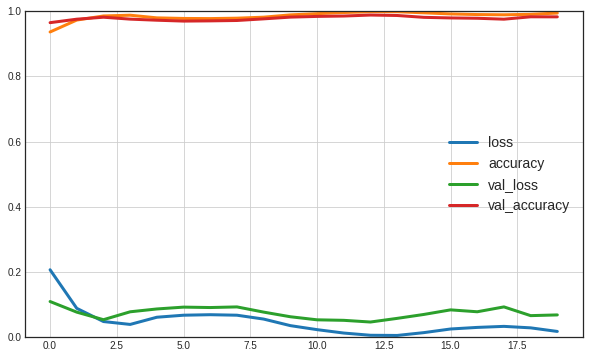

In [ ]:
# Show the learning curves
## Note: It is assumed that the training history is stored in the variable "history"
pd.DataFrame(history.history).plot()
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

In [ ]:
# show the structure of your model
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_40 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_234 (Dense)            (None, 552)               433320    
_________________________________________________________________
batch_normalization_152 (Bat (None, 552)               2208      
_________________________________________________________________
dense_235 (Dense)            (None, 552)               305256    
_________________________________________________________________
batch_normalization_153 (Bat (None, 552)               2208      
_________________________________________________________________
dense_236 (Dense)            (None, 276)               152628    
_________________________________________________________________
batch_normalization_154 (Bat (None, 276)             

## Save the model

In [ ]:
model.save('mnist.h5')

In [ ]:
# Download the model directly
from google.colab import files
files.download('mnist.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Load the model and evaluate it on the test data

In [ ]:
model = keras.models.load_model("mnist.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0470 - accuracy: 0.9879


[0.046961717307567596, 0.9879000186920166]

In [ ]:
# OWN: Model Evaluation
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0470 - accuracy: 0.9879


[0.046961717307567596, 0.9879000186920166]

## Short report

Please write briefly how you build and train the model. Please include the decisions you made, such as why you use x number layers, and the difficulties you met.

## Introduction 

In the following part we will give insight into the creation of the model, the assumptions we based our analysis on as well as the difficulties we faced while compiling the algorithm. 

In order to compile the algorithm, we first had to choose a random model to build our specifications on.

As such, we decided to follow an approach in which we use four hidden layers with an initial 500 neurons in the first layer, 200 in the second, 100 in the third and 50 in the fourth layer. We decided to choose this setting through random assignment of the number of hidden layers as well as neurons in the initial layer (we defined a range of 300 to 600 neurons, in steps of 100, as well as a range of 3 to 7 layers to choose randomly from and obtained the values of 500 and 4, respectively). Then, we deemed it necessary to follow the approach shown in the lecture and design a "triangle-like" type of network, which gradually declines in neurons per layer until it reaches its ouput layer. A possible intuition behind this might be that we can, similarly to a pooling layer, somehow decrease the density and, thus, decrease the potential to overfit throughout the layers.

Moreover, we defined the initial activation functions to be relu, which are initialised with the he_normal initializer. This decision was made on the basis of saturation as well as vanishing gradient issues, which relu is known to account for to some extent. Further, since we want a sparely-activated function, we can also profit of relu's one-sided activation characteristic. We then used the he_normal initializer to account for an improved weight initialisation, which was recommended by Haozhe in the Practical Session. 

Also, we defined an initial optimizer, which is given as Adam optimizer. This choice was also done based on recommendations given in the Practical Session. Especially, we oriented ourselves on papers (Diederik and Ba (2014), Smith (2017)) which showed the superiority of the Adam operator in optimization processes with regard to Momentum and adaptive learning rate optimizations. 

Lastly, we use a softmax activation function as well as a categorical cross-entropy loss as best practice.

In order to monitor the development of the performance of the model during training, we decide to take 6000 randomly chosen observations (i.e. 10%) of the full training data as validation data and evaluate the validation loss and validation accuracy after each epoch. We then decide to consider the validation accuracy as the best proxy for the test accuracy, which is the objective we want to maximize.

## Optimisation

Before starting with the actual model optimization, we had to evaluate whether a "triangle-shaped" neural net, implying constantly decreasing number of neurons per layer, is superior to a model which has a constant and stepwise decline of neurons per layer. Doing so would require to perform parameter updating for different model architectures. However, an issue that came to our mind was that, potentially, each architecture is differently impacted or differently impacts the other hyperparameters. As such, a different network architecture might be more prone to overfitting or could potentially better equip a certain activation function. Thus, we decided that we should solely focus on the most used network architecture for these settings, which is based on a constantly declining number of neurons (triangle shape), as otherwise the existing considerations for hyperparameter combinations might not hold any longer. 

Starting from the setting defined above, we subsequently perform hyperparameter tuning. An important question arises with regard to the order in which each hyperparameter should be tuned. This is not an intuitive point. However, when sourcing for this question online, the general opinion suggests that first the most fundamental parts of the network, such as batch sizes, epochs, hidden layers as well as number of neurons per hidden layer, should be updated before focusing on optimizing parameters and activation functions. Lastly, one should focus on learning rates and dropout regularizers. This is in part because, as argued, the learning rate is an essential parameter of the model which is likely to influence other parameters. Also, regularizer terms should be obtained at the end to account for the effective risk of overfitting. However, we decided to combat overfitting by introducing an early stopping callback, which automatically stops the training process as soon as the accuracy on the validation set did no longer increase over 7 epochs (this number has been chosen by intuitive considerations), and then chooses the model from the last 7 epochs that exhibited the largest validation accuracy. With this strategy we intend to reduce the number of hyperparameters we need to tune, since the necessity of dropout layers and kernel regularization can be avoided and the number of epochs can simply be set to an arbitrarily high number (e.g. 40). Furthermore, to enable convenient deep insights to the model we train, we additionally introduce the tensorboard callback.

As such, we follow this order when tuning the hyperparameters: 

- (Number of Epochs)
- Batch Size
- Number of Hidden Layers
- Number of Neurons per Hidden Layer
- Activation function
- Learning Rate (also experimented with CyclicLR)
- Batch-normalization
- (Drop out rate)
- (Kernel regularization)

We then chose the hyperparameters as stated above (note that the hyperparameters listed in brackets are not optimized/set in the following, as the early stopping callback already accounts for the overfitting issue). Certainly, we are aware of the fact that one could choose different orders. However, this was the most commonly used order for training artificial neural nets we encountered during our research process.

During the process, we encountered some difficulties. Realizing that performing a full grid search would take a considerable amount of time, we decide to apply the following strategy. First we search for an optimal batch size using the initial model defined above. For computational reasons, we then decided to only include the batch size that appeared to lead to the highest validation set accuracy in the initial model. Then we continue by randomly trying some intuitively/reasonably chosen values for the subsequent hyperparameter in the list stated above. The aim behind this step is to disclose a region of values for each hyperparameter, for which the respective hyperparamter appears to lead to a good performing model. This is done for each hyperparameter separeately and in the order stated above. When continuing to the next hyperparameter, the previously investigated hyperparameters are fixed to a value in the "optimal region" we obtained. In the end, we perform grid search using values from each hpyerparameter's revealed "optimal region" (except for the batch size, which we keep fixed). Furthermore, as soon as the best performing hyperparameter constellation is found, we further investigate a grid covering its close neighbourhood to hopefully find an even better performing model.

As such, we decided to start training our initial model with 8 different batch sizes, ranging from 30 to 100 by steps of 10. Doing so reveals that a batch size of 50 appears to be the best choice. Thus, we coninue to search optimal regions for the remaining hyperparameters as listed above. To do so we define the function **create_model** to create and compile a model depending on several parameters one can choose. The baseline model is similar to the initial model described above (in the sense that the same optimizer and early stopping callback are used). However, since we want the layer structure to be selectable, we use the follwong setup as a basis: a flatten layer in the beginning, a selectable number of low level hidden layers thereafter and three high level hidden layers in the end of the hidden section. The very last layer is then the output layer with 10 neurons and a softmax activation function (as is common for 10-class classification settings). The parameters one can specify in this function are the number of low level hidden layers (i.e. the argument **n_hidden**), the number of neurons in the last high level hidden layer (i.e. the argument **nh_neurons**), the activation function for the hidden layers (i.e. the argument **activ**), the learning rate of the Adam optimizer (i.e. the argument **lr**) and whether each hidden layer should be followed by a batch normalization layer or not (i.e. the boolean argument **batch_norm**). To ensure the triangle shape among the hidden layers as described above, we implemented the function such that one only has to specify the number of neurons in the deepest/last hidden layer (i.e. **nh_neurons**) - the preceding hidden layers then take an increasing number of neurons depending on **nh_neurons** up to a maximum of 560 neurons. We decided to set this ceiling value to prevent creating models with extremely many neurons in the low level hidden layers which are probably rather prone to overfitting. Thereafter, we defined a further function (i.e. the function **best_hyp**) which performs grid search among a specified grid consisting of the parameters one can choose in the **create_model** function. The **best_hyp** function then tries every possible combination in the specified grid (trained with a batch size of 50), chooses the model with the highest validation accuracy for each combination and calculates the test accuracy thereafter. After models for all combinations have been trained, the function returns the model and the paramter combination that led to the highest test accuracy. 

We then use this function to sequentially find an "optimal region" for all remaining hyperparameters. Thus, we start our search for the optimal number of hidden layers and use the following strategy: first, we set all hyperparameters listed below the number of hidden layers in the above list to a fixed value, such that the resulting model best mimics the initial model as described above (namely, we set the parameters as follows: nh_neurons = 50, activ = relu, lr = 0.001, batch_norm = False). Then, we train this model using 6 different numbers of low level hidden layers ranging from 0 to 5, which implies a range for the total number of hidden layers of 3 to 8. Doing so reveals that best number of low level hidden layers appears to be 2, which implies that 5 hidden layers in total seem to be optimal. However, since the validation accuracies of the models with 1 or 3 low level hidden layers also seem to be comparatively quite high, we define the set {1,2,3} to be the "optimal region" for this hyperparameter.

Thereafter, we fix the argument **n_hidden_range** to [2,2] and repeat the same strategy to find an optimal region for the next hyperparameter in the list - namely the number of neurons in the deepest/last hidden layer (which also influences the number of neurons in all of the other hidden layers). Here we try a grid from 30 to 100 neurons by steps of 10 (i.e. 8 different values), while all other parameters are kept fix as before. We observe that choosing 100 neurons leads to the best performance according to validation and test accuracy of the model. However, models with 70, 80 or 90 neurons in the last hidden layer appear to also perform reasonably well. Hence, we define the set {70,80,90,100} to be the "optimal region" for this hyperparameter.

We then fix the argument **nh_neurons_range** to 100 and repeat the same strategy to find an optimal set of acivation functions. Since we exclusively want to use activation functions which account for saturation and the vanishing/exploding gradient problem and also are sparely-activated, we decide to restrict the set of activation functions to use in the trial to {"relu","elu","selu"}. Considering a theoretical perspective we were uncertain whether to use a selu, relu or elu activation function, as all appear to have similar characteristics. According to Géron (2017), selu generally outperforms relu as the former is able to self-normalise and tend to preserve an output value with mean 0 and SD 1 during training, solving the vanishing gradient problem better than the relu. However, they also claim that this is rather apperent in especially deep neural networks. But having set the comparison, we figured out that using a selu activation function with a "lecun_normal" initializer in our model performs similarly well as the relu or elu activation function with "he_normal" initialization (note that the **create_model** function is implemented in such a way that the kernel initialization is automatically set to "lecun_normal" when a selu activation function is used and set to "he_normal" otherwise). Hence, we define the set {"relu","elu","selu"} to be an "optimal set" of activation functions to try among in the comprehensive grid search later on. However, since in our trial the relu activation function appears to lead to the highest test accuracy, we fix the argument **activations** to "relu" and continue with searching an optimal learning rate.

With respect to the learing rate we try a grid of values from 0.0001 to 0.001 by steps of 0.0001 (i.e. 10 different values). Here we observe somewhat ambiguous results, since values from both edges of the grid appear to perform similarly well in predicting the validation set. Since the choice of an approriate learing rate is crucial to help the model to converge more quickly, we apply a more sophisticated approach in the following. As we know, we initialised the optimizer to be Adam based on the notion that it combines two impotant considerations: Adaptive Learning rates and Momentum. As is known, Adam makes use of two sets of Moments; the first, mean-based moment as well as the second, decentralised variance moment. It also defines a certain "decay rate" which defines in which interval, or length, the moments should be adjusted. This rate is indicated by $\beta$ values, empirically found to be optimal at 0.9 and 0.99, respectively (which is the default setting). However, we decide to further tune this hyperparameter by following the approach proposed by Smith (2017). He argues that using a cyclical learning rate can additionally increase model performance as it changes parameters within a pre-defined interval according to some cycles. The idea of introducing a cyclical learning rate is to use a learning rate parameter which changes in magnitude for each cycle to gradually converge to an optimal rate such that training time and model accuracy can be improved. CLR means that the learning rate transgresses within a pre-defined interval. As such, it should address the problems of saddle points which lead to non globally optimal moments. In general, if the learning rate is at the upper bound and has a high value, the model is able to diverge quickly from saddle points, which is also given by the momentum strategy. However, this is complemented now by a lower bound, allowing us to more quickly approach a global minimum. As such, we decided to additionally constrain the optimizer function in combination with the Adam optimizer. We are then expected not only to have an adaptive learning rate focusing on two distinct moments, but also to define a gradual direction of the adaptive learning rate including decay parameters and a given range. That is, we put an additional, iterative constraint on our momentum strategy with Adam and its beta values. To set up the cyclical learning rate callback appropriately, we are required to find some upper and lower bound as well as a cycle length, indicating the length of each max-min circuit. To do so, we follow the argumentation of Smith (2017): 

1. The cycle length (or step size) should be between 2-10 times the number of iterations divided by the batch size. Hence, we choose the step size to be $\frac{5*N}{10}$ (where N stands for the number of observations in the training data).
2. The min and max values for the learning rate are given through an iterative training process similar to defining the initial learning rate in different settings. We just ran the model for different learning rates between 0.0001 and 0.001 and observed that the performance of the models did not vary too much. Hence, we choose 0.0001 as the lower bound and 0.001 as the upper bound.

Another advantage when working with a cyclical learning rate is that the selection of the initial learning rate becomes a minor concern, as the learning is anyway changing during the training process. Hence, we simply set the initial learing rate to be 0.0009, as this value appeared to lead to the best performing model in the according grid search described above. We observe that using a cyclical learning rate indeed increases the prediction accuracy of the model, while also causing the model to converge rather quickly. Hence, we decide to apply the cyclical learing rate strategy with an initial learning rate fixed to 0.0009 in all of the subsequent models.

Lastly, we wanted to assess whether batch normalization leads to a substantial improvement of the mode performance. Running the model (with all previously analyzed hyperparameters fixed as described above) once with batch normalization and once without reveals that both approaches lead to similar results. Hence, we decide to keep both options for the **batch_norm** argument - True and Flase - in the grid while performing the comprehensive grid search.

We then were set to perform the final grid search procedures using values from each hpyerparameter's revealed "optimal region". To gain robustness we perform the same grid search twice, to check whether the resulting best models are similar in both runs. Doing so reveals that the best performing model has the following hyperparameter constellation: 5 hidden layers, 70 or 80 neurons in the last hidden layer, selu or elu activation function, cyclical learing rate with 0.0009 as the initial value and batch normalization activated.

To proceed, we decide to fix the number of hidden layers to be 5 and the batch normalization to remain avtivated. Furthermore, we refine the grid for the number of neurons in the deepest/last hidden layer such that it is {65,70,75,80,85} and reduce the set of activation functions to {elu,selu}. We then left the initial learning rate unchanged and repeated the grid search (to gain robustness, we again performed the grid search twice for this setting). Doing so reveals that the best performing model has the following hyperparameter constellation: 5 hidden layers, once 70 and once 85 neurons in the last hidden layer, elu activation function, cyclical learing rate with 0.0009 as the initial value and batch normalization activated.

We then turned to the last grid search section. Since we observed that the elu activation function (with he_normal weight initialization) appears to lead to the best performing models for two different number of neurons in the last hidden layer (i.e. 70 and 85), we decide to fix the activation functions to be elu and search for good performing models in the close neighbourhood of both optimal number of neurons for the ultimate hidden layer. Hence, we perform a grid search using the following two grids for the number of neurons in the last hidden layer: {67,68,69,70,71,72,73} and {82,83,84,85,86,87,88}. The remaining hyperparamters are again left unchanged. Doing so reveals that the following two hyperparameter constellations appear to be optimal:

1. 5 hidden layers, 69 neurons in the last hidden layer, elu activation function, cyclical learing rate with 0.0009 as the initial value and batch normalization activated

2. 5 hidden layers, 86 neurons in the last hidden layer, elu activation function, cyclical learing rate with 0.0009 as the initial value and batch normalization activated

As a last step we then trained models with these two specifications multiple times, and selected the model that appeared to lead to the highest prediction accuracy on the test set as our final model.

## Assessment

Having followed state-of-the-art methods defined on our own setting, we are able to construct an iterative tuning process in which we re-evaluated the most prominent parameters of a neural network. All things considered, the iterative process was able to suit the requirements given by the task and even to exceed them. With an overall test set accuracy of 0.9879, we were able to outperform the requested threshold of 0.97 and obtain a sufficient model. Especially, we were able to understand that a cyclic learning rate, batch normalization as well as early stopping features can substantially improve the accuracy of the network even after the main parameters are optimised. As such, the cyclic learning rate appears to well account for the issue of saddle points during the optimization pocess. Further, the early stopping callback also is able to account well for the case of an overfitting network.

In order to be able to further improve the model, one would require to use different methods, such as convolutional filters and pooling layers.